# Figures

This notebook will be used to generate nice figures to be used in the report.

In [1]:
import numpy as np
import astropy
import matplotlib.pyplot as plt 
from matplotlib import cm

## Isochrones - Nico Keeghan
The following code will generate the isochrone figures. This code has been taken directly from the `isochrones.ipynb` notebook, and modified slightly to make the figures nicer.

We first read in the magnitudes.

In [2]:
from astropy.table import QTable

mags = QTable.read("../obj_magnitudes.ecsv", format='ascii.ecsv')

We define a class to store the isochrone data.

In [3]:
# Code adapted from Girardi_UBVRI.ipynb on Moodle

class isochroneclass:
    def __init__(self):
            self.filename = "NULL                            "      # Relevant filename
            self.age = -99.0                                        # Age (log)
            self.m = []                                   # Star masses
            self.U = []                                   # Star U-band magnitudes
            self.B = []                                   # Star B-band magnitudes
            self.V = []                                   # Star V-band magnitudes
            self.R = []                                   # Star R-band magnitudes
            self.I = []                                   # Star I-band magnitudes

We read in the isochrones.

In [4]:
# Adapted from Girardi_UBVRI.ipynb on Moodle

fnames = ['../isochrones/output545039620091_1e7_1e8.dat','../isochrones/output410618231006_1e6_to_15e6.dat']
isochrones = {}

for fname in fnames:
    f=open(fname,"r")
    lines=f.readlines()

    curr_age = -99.0

    # iterate through lines of data file and add relevant information to ic object
    for x in lines:
        if x[0]!='#':
            split_line = x.split()
            age = float(split_line[2])
            if age != curr_age:
                if curr_age > -99.0:
                    isochrones[curr_age] = ic
                ic=isochroneclass()               # create new ic class
                curr_age = age                    # update current age
                ic.age = curr_age                 # set age for new isochrone
            ic.m.append(float(split_line[5]))     # mass of star
            ic.U.append(float(split_line[28]))    # U-band magnitude
            ic.B.append(float(split_line[29]))    # B-band magnitude
            ic.V.append(float(split_line[30]))    # V-band magnitude
            ic.R.append(float(split_line[31]))    # R-band magnitude
            ic.I.append(float(split_line[32]))    # I-band magnitude

    isochrones[curr_age] = ic

    f.close()



Now we plot the offset isochrones and the extinction and reddening corrected stars as determined in the `isochrones.ipynb` notebook.

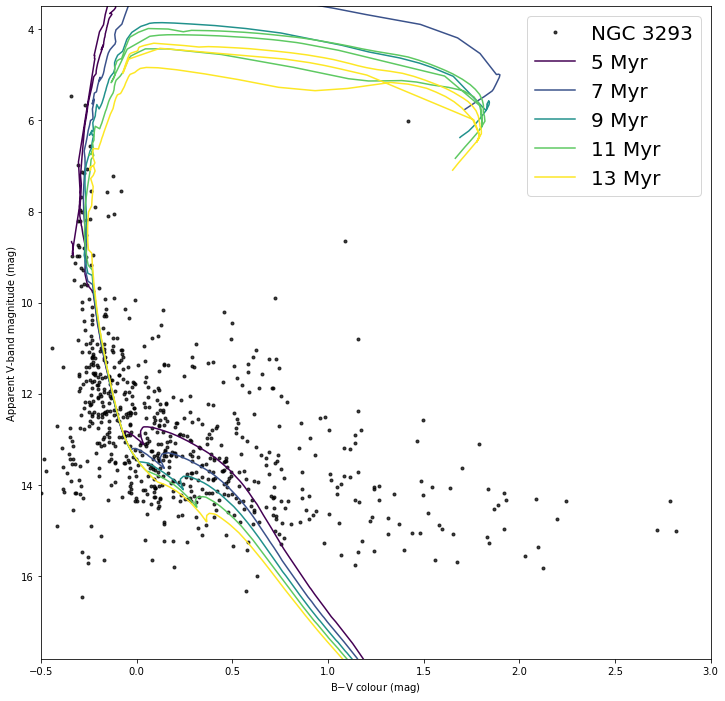

In [5]:
extinction = 1
reddening = extinction/3.1
offset = 11.8

px = mags['Bmag'] - mags['Vmag'] - reddening   # plot B-V colour on x-axis
py = mags['Vmag'] - extinction                 # plot V-band magnitude on y-axis


# isochrones of log(age) that we are interested in, corresponding to ages between 5 and 15 Myr.
ages = [6.69897, 6.8451, 6.95424, 7.04139, 7.11394]

# get some sequential colors to plot with to easily see the differences due to age
colors = cm.viridis(np.linspace(0,1,len(ages)))

fig, ax = plt.subplots(figsize = (12,12))

plt.rcParams.update({'font.size': 20})
plt.plot(px, py, '.', color='black',label='NGC 3293',alpha=0.75)

for age,color in zip(ages,colors):
    BV=np.array(isochrones[age].B)-np.array(isochrones[age].V)
    offsetV = np.array(isochrones[age].V) + offset

    plt.plot(BV, offsetV, color=color, label='{:.0f} Myr'.format(10**(isochrones[age].age-6)))

plt.xlabel('B$-$V colour (mag)')
plt.ylabel('Apparent V-band magnitude (mag)')

# set y-axis limits so we can see the stars
plt.ylim(3.5,max(py))
plt.xlim(-0.5,3)

# invert y-axis so brighter stars are at the top
ax.invert_yaxis()

plt.legend(loc='upper right')

plt.savefig('isochrones.pdf')

plt.show()

Now I want to identify the stars that we classified as members and non-members.

We start by reading in the ids for the stars that we classified as field stars in the `isochrones.ipynb` notebook.

In [6]:
import csv
removed_ids = []
with open('../removed_ids.dat') as f:
    reader = csv.reader(f,delimiter='\n')
    for row in reader:
        row = row[0].strip(' ').strip(',')
        if row.isnumeric():
            removed_ids.append(int(row))

Now we filter out the field stars.

In [7]:
Mv_filtered = [mags['Vmag'][i] - extinction for i in range(len(mags['id'])) if (mags['id'][i] not in removed_ids)]
BV_filtered = [mags['Bmag'][i] - mags['Vmag'][i] - reddening for i in range(len(mags['id'])) if (mags['id'][i] not in removed_ids)]

Finally, we plot the optimal isochrone, with the stars that we classified as field stars and member stars marked.

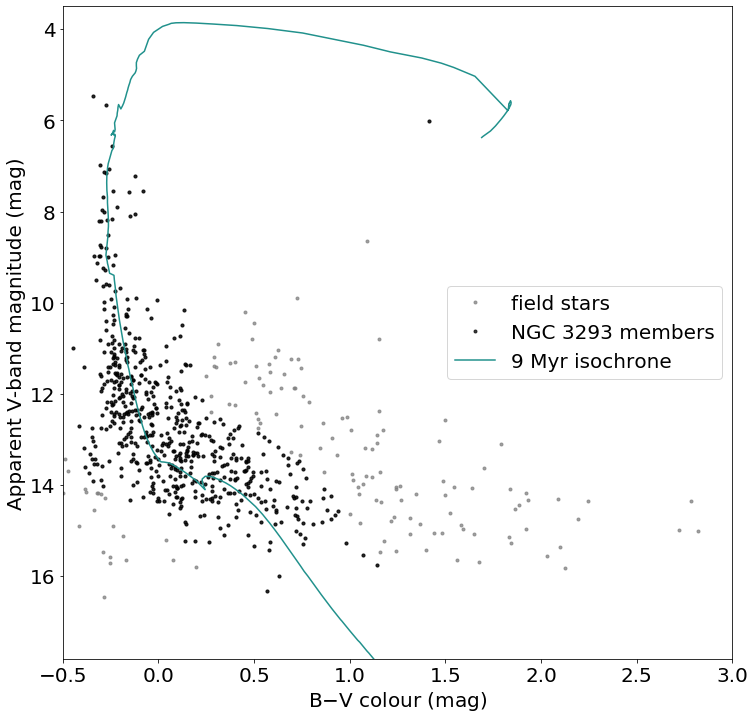

In [8]:
offset = 11.8

# isochrone of age = 9 Myr (10**age = 9*10**6).
age = 6.95424

fig, ax = plt.subplots(figsize = (12,12))

plt.rcParams.update({'font.size': 20})
plt.plot(px, py, '.', color='gray',label='field stars',alpha=0.75)
plt.plot(BV_filtered, Mv_filtered, '.', color='black',label='NGC 3293 members',alpha=0.75)


BV=np.array(isochrones[age].B)-np.array(isochrones[age].V)
offsetV = np.array(isochrones[age].V) + offset

plt.plot(BV, offsetV, color=colors[2], label='{:.0f} Myr isochrone'.format(10**(age-6)))

plt.xlabel('B$-$V colour (mag)')
plt.ylabel('Apparent V-band magnitude (mag)')

# set y-axis limits so we can see the stars
plt.ylim(3.5,max(py))
plt.xlim(-0.5,3)

# invert y-axis so brighter stars are at the top
ax.invert_yaxis()

plt.legend()

plt.savefig('best_fit_isochrone_with_filtering.pdf')

plt.show()

## Luminosity Function - Nico Keeghan

The following code will produce the luminosity function histogram, using bins of width 1 mag.

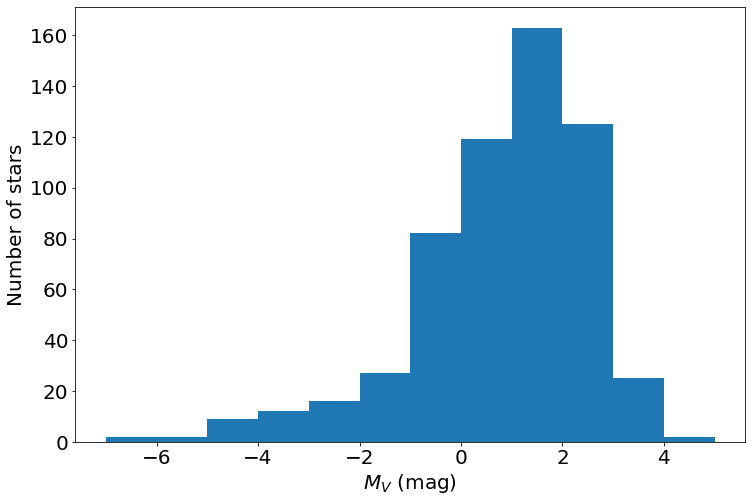

In [51]:
fig, ax = plt.subplots(figsize = (12,8))

bins = [i for i in range(int(min(Mv_filtered))-1,int(max(Mv_filtered))+2)]

num, bins, patch = plt.hist(Mv_filtered, bins=bins)
plt.ylabel('Number of stars')
plt.xlabel('$M_V$ (mag)')

plt.savefig('M_V_histogram.pdf')
plt.show()

# Mass - Luminosity Relation

The code below will generate figures for the mass-luminosity relation. This is discussed in the `mass_luminosity.ipynb` notebook.

First we need the masses. This uses the code written by Cedric in the `masses.ipynb` notebook to determine the masses from the B-V colour.

In [6]:
# from masses.ipynb notebook
from PyAstronomy import pyasl
b = pyasl.BallesterosBV_T()

bvs = [{'id': row['id'], 'bv':(bv := row['Bmag']-row['Vmag']-reddening), 'temp':b.bv2T(bv)}
       for row
       in mags
       # filtering for the removed stars
       if int(row['id']) not in removed_ids
       ]


In [7]:
# from masses.ipynb notebook
def t2mratio(teff):
    logteff = np.log10(teff)

    # out of range of fit
    if logteff < 3.453 or logteff > 4.613:
        return None

    if logteff < 3.523:
        logmratio = (-2.781774*10**1) + 7.786002*logteff

    # apply polynomial.
    else:
        logmratio = (
            (-8.448396*10**1) +
            (6.094505*10**1)*logteff +
            (-1.489538*10**1)*logteff**2 +
            (1.240992)*logteff**3
        )
    
    return 10**logmratio


In [8]:
# from masses.ipynb notebook
for d in bvs:
    d['massratio'] = t2mratio(d['temp'])

# remove invalid elements which were out of the range of fit
bvs = [bv for bv in bvs if bv['massratio']]

In [9]:
# from masses.ipynb notebook
masslist = [star['massratio'] for star in bvs]

Now to plot mass against luminosity. The giant star has been excluded. I have used the equation
$$L = L_\odot 10^{(M_\odot-M_V)/2.5},$$

assuming that the Sun has a V-band absolute magnitude of 4.81 mag (Willmer 2018, DOI = 10.3847/1538-4365/aabfdf).

Slope: 2.1319438058571203
Intercept: 0.761122859261303


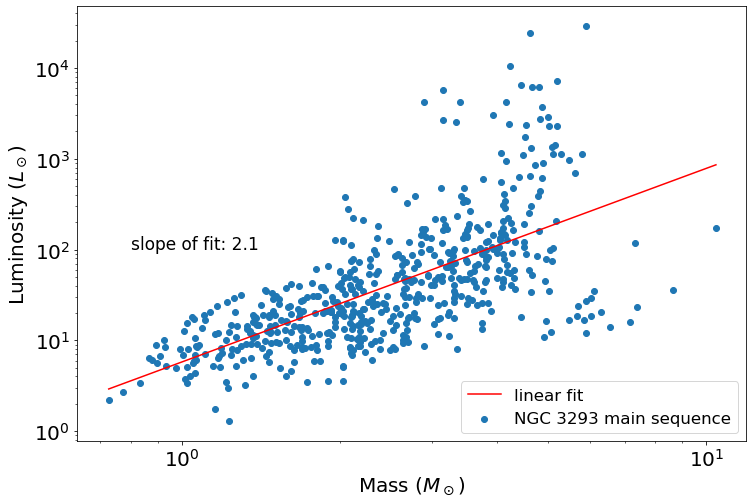

In [33]:
giant_idx = np.argmin(masslist)
masslist_no_giant = masslist[:giant_idx] + masslist[giant_idx+1:]
Mv_filtered_no_giant = np.concatenate((Mv_filtered[:giant_idx], Mv_filtered[giant_idx+1:]))
L = 10**((4.81-Mv_filtered_no_giant)/2.5)


m,c =np.polyfit(np.log10(masslist_no_giant),np.log10(L),1)
x = np.linspace(min(masslist_no_giant),max(masslist_no_giant),10)
y = 10**c*x**m

print('Slope:', m)
print('Intercept:',c)
slope_text = 'slope of fit: %.1f' % m


fig,ax = plt.subplots(figsize = (12,8))
plt.rcParams.update({'font.size':20})
plt.scatter(masslist_no_giant,L,label='NGC 3293 main sequence')
plt.plot(x,y,color='red',label='linear fit')
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Luminosity ($L_\odot$)')
plt.legend(fontsize='small',loc='lower right')
plt.text(x=0.8,y=100,s=slope_text,fontdict={'fontsize':17})
plt.xscale('log')
plt.yscale('log')
plt.savefig('mass_luminosity_relation.pdf')
plt.show()